<a href="https://colab.research.google.com/github/binliu0630/Machine_Learning/blob/master/H2o_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Env

In [0]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.10-63ubuntu1~02).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
openjdk version "10.0.2" 2018-07-17
OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4)
OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)


In [0]:
! pip install h2o

    100% |████████████████████████████████| 120.9MB 168kB/s 
  Stored in directory: /root/.cache/pip/wheels/80/d9/27/eba7cef0f0cacb7a31fa32d7086dec0c9726d770593e374e7c
Successfully built h2o


In [0]:
import h2o
h2o.init(max_mem_size='12G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxr4vp6l3
  JVM stdout: /tmp/tmpxr4vp6l3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxr4vp6l3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_unknownUser_vsnjvv
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


# DATA

In [0]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/nlp/AmazonReviews.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"


# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
#reviews['PositiveReview'] = reviews['Score']>=4
reviews['PositiveReview'] = (reviews['Score'] >= 4).ifelse('1','0')


In [0]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,21791
1,78209


In [0]:
# find the 80th quantile of time
time_split=reviews['Time'].quantile(prob=[0.8])[1]
reviews['Train']= (reviews['Time'] < time_split).ifelse('Yes', 'No')

In [0]:
reviews.head(1)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No


In [0]:
reviews.names

['ProductId',
 'UserId',
 'Summary',
 'Score',
 'HelpfulnessDenominator',
 'Id',
 'ProfileName',
 'HelpfulnessNumerator',
 'Time',
 'Text',
 'PositiveReview',
 'Train']

In [0]:
import pandas as pd
import os
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator, H2ODeepWaterEstimator


# Train Base Model

In [0]:
train = reviews[reviews['Train']== 'Yes']
valid = reviews[reviews['Train'] == 'No']

In [0]:
predictors = ['ProductId', 'UserId', 'HelpfulnessDenominator','HelpfulnessNumerator', 'Time']
response='PositiveReview'

In [0]:
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = 'AUC',
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10,
                                           model_id = 'gbm_baseline.hex')

In [0]:
gbm_baseline.train(x = predictors, y=response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'gbm_baseline AUC on Validation Data: {round(gbm_baseline.auc(valid=True),3)}')

gbm_baseline AUC on Validation Data: 0.616


In [0]:
gbm_baseline.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,0,1,Error,Rate
0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,128.0,15220.0,0.0083,(128.0/15348.0)
Total,512.0,19496.0,0.2201,(4404.0/20008.0)


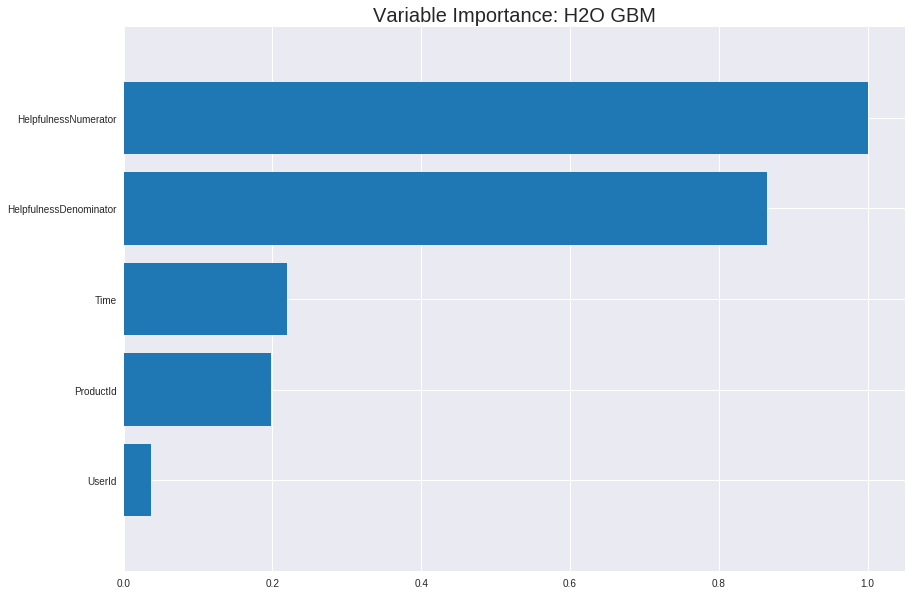

In [0]:
gbm_baseline.varimp_plot()

# Tokenize

In [0]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package


# download from GitHub
data_path = "https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/h2o-world-2017/nlp/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [0]:
len(STOP_WORDS)

153

In [0]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+") # tokenized by words, which will remove all the other special character, such as "", [], punctuations
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:] # use invet = true to extract non number tokenzies
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:] 
    return tokenized_words

In [0]:
words = tokenize(reviews['Text'])
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


# Train Word2Vec Model

In [0]:
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [0]:
#w2v_model = h2o.load_model(w2v_path)

In [0]:
w2v_model.find_synonyms('coffee', count = '5')

OrderedDict([('coffe', 0.8011164665222168),
             ('espresso', 0.795991063117981),
             ('coffees', 0.7906833291053772),
             ('expresso', 0.7733843326568604),
             ('brewed', 0.734802782535553)])

In [0]:
# caculate the vec for each review
review_vecs = w2v_model.transform(words, aggregate_method = 'AVERAGE')

In [0]:
# add review with embeddings
ext_reviews = reviews.cbind(review_vecs)

In [0]:
ext_reviews.head(2)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.0334397,0.0587224,-0.0973916,0.0507354,0.00100041,-0.0687384,0.110034,0.030858,-0.0303245,-0.224132,-0.0255798,0.0846478,0.0893458,0.0950163,-0.00138842,-0.110421,-0.203488,0.0835663,-0.0341124,0.00538144,-0.0647419,0.164127,-0.035758,-0.040013,-0.0330751,0.106238,0.0886508,0.111887,0.04447,0.17318,-0.00590384,-0.14619,-0.0317761,0.0623553,-0.127708,0.00689686,0.117939,0.0132855,-0.00360485,0.0650234,0.233051,-0.0156746,-0.0760735,0.258833,0.219453,0.142825,0.0470135,0.0386686,-0.109914,0.110689,-0.00866727,-0.0923441,0.133245,-0.00116396,-0.107254,-0.165806,0.0898597,-0.0226412,0.0532929,-0.0255545,-0.170299,-0.00752662,0.10511,-0.0986587,-0.0628334,0.0207825,-0.0980293,0.0445809,-0.152882,-0.150627,0.0660375,0.0367726,0.1755,0.0547301,0.139016,0.0138052,0.0942586,-0.0771686,0.19868,-0.0902037,0.124137,0.0109686,0.151732,-0.0246483,0.0220815,0.0760319,-0.129161,0.0555044,0.0485086,0.15101,-0.0095916,0.214063,-0.00148241,-0.0495808,-0.136553,-0.0988832,-0.0712226,0.0317462,-0.0840614,0.158959
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,0.083247,0.102869,0.0455119,-0.0526213,0.153833,-0.152002,-0.0174297,-0.00895996,-0.235187,-0.171868,-0.264151,-0.0393934,0.130923,-0.108746,-0.00239468,0.000110046,-0.0646377,0.0374242,-0.207679,-0.0394262,-0.0224235,0.133269,0.0428463,-0.00883173,0.0549509,0.13223,0.102811,0.0602145,-0.0868577,0.066324,-0.0211561,0.0777884,-0.0484114,0.112608,0.0312672,0.0404489,-0.0416478,0.129834,-0.189087,-0.147081,-0.0568603,0.0258648,-0.0515194,0.174433,0.0907776,0.229658,-0.0600743,0.0601609,-0.00484006,0.0784584,0.144101,-0.048168,0.122465,-0.0866785,0.00855735,0.160046,0.0777081,-0.00017756,0.135043,0.0919474,-0.0604595,0.113629,-0.0672977,-0.100793,-0.159366,-0.000354876,-0.0724062,0.0981881,0.0435634,-0.0215086,0.0861978,-0.0452177,0.0862949,-0.0894611,0.131223,0.041581,-0.0409549,0.0935415,0.146042,-0.0317286,0.0370589,-0.210835,0.068625,-0.00252465,0.000591666,0.163246,-0.0895924,0.080304,0.115315,-0.0533618,-0.109371,0.0403049,0.149495,-0.0255583,-0.152807,-0.137803,-0.136431,0.078818,0.114668,0.0376616


#Train GBM with embeddings

In [0]:
ext_train = ext_reviews[ext_reviews['Train'] == 'Yes']
ext_test = ext_reviews[ext_reviews['Train'] == 'No']

In [0]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

In [0]:
gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'gbm_embeddings AUC on Validation Data: {round(gbm_embeddings.auc(valid=True),3)}')

gbm_embeddings AUC on Validation Data: 0.875


In [0]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6162850606641161: 


,0,1,Error,Rate
0,2376.0,2284.0,0.4901,(2284.0/4660.0)
1,842.0,14506.0,0.0549,(842.0/15348.0)
Total,3218.0,16790.0,0.1562,(3126.0/20008.0)


In [0]:
gbm_embeddings.accuracy(valid = True)

[[0.6256070762038872, 0.84406237504998]]

In [0]:
gbm_embeddings.mcc(valid = True)

[[0.6995370382151705, 0.5410850212803776]]

In [0]:
gbm_embeddings.F0point5()

[[0.7410465000049117, 0.9253605465126086]]

# Adding Summary

In [0]:
summary_words = tokenize(reviews['Summary'].ascharacter())

In [0]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method = 'AVERAGE')
summary_vecs.names = ['summary_'+s for s in summary_vecs.names]
ext_reviews = ext_reviews.cbind(summary_vecs)

In [0]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]


In [0]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

In [0]:
# gbm
gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex"
                                             )
gbm_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'gbm_plus_summary AUC on Validation Data: {round(gbm_plus_summary.auc(valid=True),3)}')

gbm_plus_summary AUC on Validation Data: 0.912


In [0]:
# rf
rf_plus_summary = H2ORandomForestEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "rf_plus_summary.hex"
                                             )
rf_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [0]:
print(f'rf_plus_summary AUC on Validation Data: {round(rf_plus_summary.auc(valid=True),3)}')

rf_plus_summary AUC on Validation Data: 0.901


In [0]:
# dp
dp_plus_summary = H2ODeepLearningEstimator( model_id = "dp_plus_summary.hex",
  hidden=[32,32,32],                  ## small network, runs faster
    epochs=1000000,                      ## hopefully converges earlier...
    score_validation_samples=10000,      ## sample the validation dataset (faster)
    stopping_rounds=2,
    stopping_metric="misclassification", ## alternatives: "MSE","logloss","r2"
    stopping_tolerance=0.01)

dp_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

print(f'dp_plus_summary AUC on Validation Data: {round(dp_plus_summary.auc(valid=True),3)}')

deeplearning Model Build progress: |██████████████████████████████████████| 100%
dp_plus_summary AUC on Validation Data: 0.931


In [0]:
print(dp_plus_summary)

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  dp_plus_summary.hex


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.07289456231589851
RMSE: 0.269989930026841
LogLoss: 0.24157669350655506
Mean Per-Class Error: 0.1283463841547674
AUC: 0.9458937745810155
pr_auc: 0.881320144538513
Gini: 0.8917875491620311
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4698052565953447: 


,0,1,Error,Rate
0,1440.0,731.0,0.3367,(731.0/2171.0)
1,247.0,7553.0,0.0317,(247.0/7800.0)
Total,1687.0,8284.0,0.0981,(978.0/9971.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4698053,0.9391942,242.0
max f2,0.2077304,0.9629731,318.0
max f0point5,0.8168448,0.9410943,131.0
max accuracy,0.5875950,0.9025173,210.0
max precision,0.9998383,1.0,0.0
max recall,0.0045400,1.0,396.0
max specificity,0.9998383,1.0,0.0
max absolute_mcc,0.7187041,0.7092216,168.0
max min_per_class_accuracy,0.8653158,0.8685897,110.0
max mean_per_class_accuracy,0.8786431,0.8716536,103.0


Gains/Lift Table: Avg response rate: 78.23 %, avg score: 80.57 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100291,0.9999882,1.2783333,1.2783333,1.0,0.9999958,1.0,0.9999958,0.0128205,0.0128205,27.8333333,27.8333333
,2,0.0200582,0.9999616,1.2783333,1.2783333,1.0,0.9999766,1.0,0.9999862,0.0128205,0.0256410,27.8333333,27.8333333
,3,0.0300873,0.9999258,1.2783333,1.2783333,1.0,0.9999447,1.0,0.9999724,0.0128205,0.0384615,27.8333333,27.8333333
,4,0.0400160,0.9998761,1.2783333,1.2783333,1.0,0.9999031,1.0,0.9999552,0.0126923,0.0511538,27.8333333,27.8333333
,5,0.0500451,0.9998035,1.2783333,1.2783333,1.0,0.9998416,1.0,0.9999324,0.0128205,0.0639744,27.8333333,27.8333333
,6,0.1000903,0.9992999,1.2732098,1.2757715,0.9959920,0.9995846,0.9979960,0.9997585,0.0637179,0.1276923,27.3209753,27.5771543
,7,0.1500351,0.9984257,1.2757664,1.2757698,0.9979920,0.9988989,0.9979947,0.9994723,0.0637179,0.1914103,27.5766399,27.5769831
,8,0.2000802,0.9971822,1.2757715,1.2757703,0.9979960,0.9978411,0.9979950,0.9990643,0.0638462,0.2552564,27.5771543,27.5770259
,9,0.3000702,0.9931527,1.2667937,1.2727791,0.9909729,0.9954253,0.9956551,0.9978517,0.1266667,0.3819231,26.6793714,27.2779078
,10,0.4000602,0.9858842,1.2655115,1.2709626,0.9899699,0.9898129,0.9942341,0.9958425,0.1265385,0.5084615,26.5511535,27.0962647




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.08694346501526048
RMSE: 0.2948617727262394
LogLoss: 0.28613206526407914
Mean Per-Class Error: 0.14600034553205843
AUC: 0.9311850485728614
pr_auc: 0.9283411495157075
Gini: 0.8623700971457229
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5475466193385452: 


,0,1,Error,Rate
0,1609.0,777.0,0.3256,(777.0/2386.0)
1,382.0,7245.0,0.0501,(382.0/7627.0)
Total,1991.0,8022.0,0.1157,(1159.0/10013.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5475466,0.9259378,217.0
max f2,0.1952309,0.9557367,322.0
max f0point5,0.8587113,0.9283309,110.0
max accuracy,0.5872652,0.8848497,204.0
max precision,0.9998783,1.0,0.0
max recall,0.0008263,1.0,399.0
max specificity,0.9998783,1.0,0.0
max absolute_mcc,0.7155523,0.6769454,166.0
max min_per_class_accuracy,0.8676748,0.8516345,106.0
max mean_per_class_accuracy,0.9030440,0.8539997,87.0


Gains/Lift Table: Avg response rate: 76.17 %, avg score: 79.16 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100869,0.9999569,1.3128360,1.3128360,1.0,0.9999823,1.0,0.9999823,0.0132424,0.0132424,31.2835977,31.2835977
,2,0.0200739,0.9998764,1.3128360,1.3128360,1.0,0.9999205,1.0,0.9999516,0.0131113,0.0263537,31.2835977,31.2835977
,3,0.0300609,0.9997964,1.3128360,1.3128360,1.0,0.9998372,1.0,0.9999136,0.0131113,0.0394651,31.2835977,31.2835977
,4,0.0400479,0.9997120,1.3128360,1.3128360,1.0,0.9997525,1.0,0.9998734,0.0131113,0.0525764,31.2835977,31.2835977
,5,0.0500350,0.9995597,1.2997076,1.3102155,0.99,0.9996457,0.9980040,0.9998280,0.0129802,0.0655566,29.9707618,31.0215546
,6,0.1000699,0.9987379,1.3102155,1.3102155,0.9980040,0.9991640,0.9980040,0.9994960,0.0655566,0.1311132,31.0215546,31.0215546
,7,0.1500050,0.9975241,1.3102103,1.3102138,0.998,0.9981852,0.9980027,0.9990596,0.0654255,0.1965386,31.0210305,31.0213802
,8,0.2000399,0.9957869,1.3023543,1.3082479,0.9920160,0.9966949,0.9965052,0.9984681,0.0651632,0.2617018,30.2354253,30.8247934
,9,0.3000100,0.9906114,1.2957862,1.3040954,0.9870130,0.9934353,0.9933422,0.9967911,0.1295398,0.3912416,29.5786160,30.4095392
,10,0.3999800,0.9809595,1.2800479,1.2980850,0.9750250,0.9862558,0.9887640,0.9941579,0.1279664,0.5192081,28.0047866,29.8085011



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-03-08 19:22:00,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-03-08 19:22:01,1 min 32.435 sec,83 obs/sec,0.0007251,1,58.0,0.4079086,0.6090541,0.0231031,0.7456298,0.8841117,1.1888500,0.2021863,0.4144107,0.5960832,0.0538364,0.7516777,0.8798160,1.2868392,0.2203136
,2019-03-08 19:37:09,16 min 18.497 sec,68 obs/sec,0.6997450,940,55974.0,0.2844711,0.2675094,0.5248842,0.9313885,0.8985643,1.2783333,0.1101193,0.3021973,0.2991631,0.4968639,0.9210241,0.8945606,1.3128360,0.1234395
,2019-03-08 19:48:39,27 min 47.587 sec,69 obs/sec,1.2507876,1671,100053.0,0.2752519,0.2515832,0.5551807,0.9395109,0.9320354,1.2783333,0.0989871,0.2988124,0.2919873,0.5080720,0.9262745,0.9247934,1.3128360,0.1210426
,2019-03-08 19:59:58,39 min 8.176 sec,70 obs/sec,1.7973422,2396,143773.0,0.2699899,0.2415767,0.5720253,0.9458938,0.8813201,1.2783333,0.0980844,0.2948618,0.2861321,0.5209937,0.9311850,0.9283411,1.3128360,0.1157495
,2019-03-08 20:11:36,50 min 43.434 sec,70 obs/sec,2.3462471,3131,187681.0,0.2667831,0.2357877,0.5821317,0.9486766,0.8883585,1.2783333,0.0940728,0.2992927,0.2901588,0.5064893,0.9270269,0.9122104,1.3128360,0.1210426
,2019-03-08 20:22:46,1:01:54.320,70 obs/sec,2.8740624,3840,229902.0,0.2627447,0.2309336,0.5946866,0.9507445,0.8810353,1.2783333,0.0903620,0.2988881,0.2932902,0.5078227,0.9284893,0.8649421,1.3128360,0.1183462
,2019-03-08 20:23:55,1:03:04.911,70 obs/sec,2.8740624,3840,229902.0,0.2699899,0.2415767,0.5720253,0.9458938,0.8813201,1.2783333,0.0980844,0.2948618,0.2861321,0.5209937,0.9311850,0.9283411,1.3128360,0.1157495


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
HelpfulnessDenominator,1.0,1.0,0.0005071
HelpfulnessNumerator,0.8006563,0.8006563,0.0004060
C12,0.4162957,0.4162957,0.0002111
C38,0.3544875,0.3544875,0.0001798
C4,0.3371142,0.3371142,0.0001710
---,---,---,---
UserId.A1U7I5FLLR1MMF,0.0112911,0.0112911,0.0000057
ProductId.B004P7T7RG,0.0112210,0.0112210,0.0000057
UserId.A25H6QFR7T8YF6,0.0104609,0.0104609,0.0000053
UserId.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()



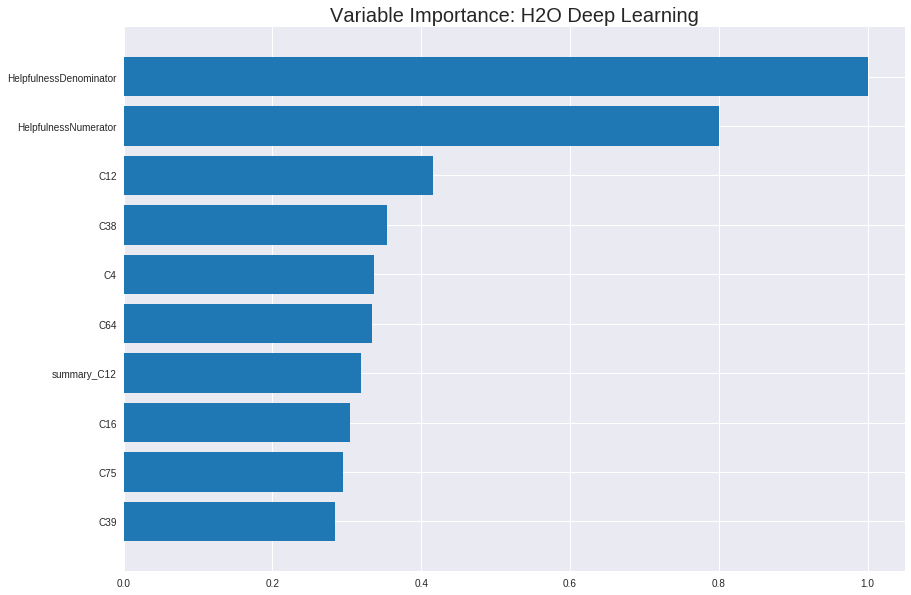

In [0]:
dp_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


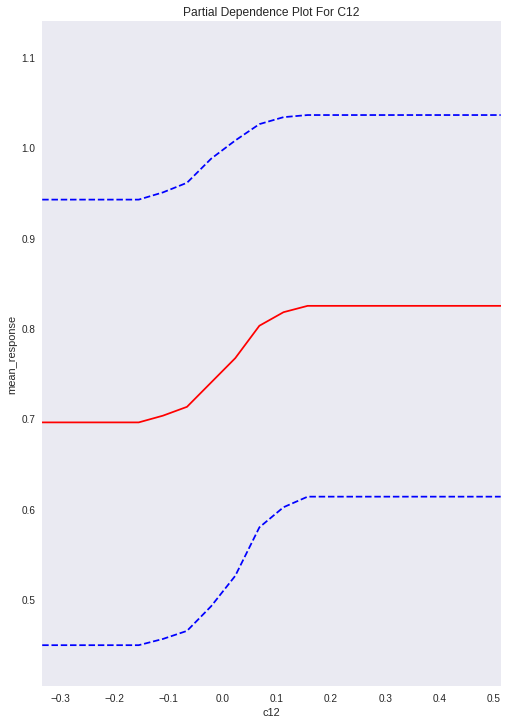

In [0]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data = ext_train, cols = ['C12'])

In [0]:
# Get Word Embeddings per Word
unique_words = summary_words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]
word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]

In [0]:
word_embeddings

Word,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
aa,0.029092,-0.117329,0.0537625,-0.0697117,0.287874,-0.00254658,0.210048,-0.136762,0.0427679,-0.334558,-0.355636,0.579245,-0.495021,0.270712,-0.0687201,-0.730787,-0.0170917,0.35515,-0.0558159,-0.259497,0.188917,-0.0307768,-0.17509,-0.177578,0.458032,0.0366684,0.0551966,0.101793,0.0659445,-0.361489,-0.480904,-0.0313347,-0.0191771,-0.196597,-0.0757096,0.306963,-0.100564,-0.559201,0.0258643,-0.0533983,-0.283671,-0.273267,-0.179011,-0.312378,-0.183994,0.0770409,-0.156881,-0.127337,-0.0677455,0.21665,0.201273,-0.607145,0.0708613,0.294312,-0.431302,-0.381131,0.0548497,-0.0192432,0.336144,0.385707,-0.165109,-0.213158,-0.0669555,-0.0242088,-0.1039,-0.11178,0.160233,0.016812,0.409889,0.266545,0.691305,-0.207976,-0.102854,-0.0932306,-0.00126054,-0.0603053,0.548074,-0.196542,-0.409358,-0.0258621,0.175579,-0.312181,0.280491,-0.350192,0.0191343,0.312428,-0.0828037,0.172727,-0.375991,-0.130456,0.0738062,0.529666,-0.268026,-0.079465,-0.571229,-0.716438,-0.343874,0.0314978,0.260141,0.143972
aaa,-0.124209,0.145792,-0.156906,0.0116735,-0.0366009,-0.25514,0.00987346,-0.131123,-0.3346,-0.16908,-0.0535209,0.096909,-0.0220011,0.0326328,-0.0421776,-0.212571,0.160064,0.0644105,-0.186383,-0.136889,0.19961,0.115175,0.0388524,0.0227902,0.126286,0.212425,0.145658,0.179555,-0.124992,0.210767,0.0814623,-0.0770555,0.00265771,0.0453787,0.0836823,-0.0937575,0.280179,-0.00510491,0.237304,-0.0196796,0.139403,-0.150945,-0.0181001,0.158317,0.162923,0.0970619,-0.113827,0.0362514,-0.151963,0.107428,-0.0440289,0.31353,0.0666288,0.128978,-0.0464596,-0.101648,0.0461971,0.0256168,0.21315,0.127023,-0.0988737,0.130559,0.0674882,0.0183614,-0.154388,-0.105995,-0.278653,0.0319618,-0.0822952,-0.118171,0.0340789,-0.11196,-0.0186627,-0.133128,-0.0841192,0.156409,-0.110417,-0.126851,0.0272573,0.228992,0.207671,0.2134,-0.114773,0.0794591,0.124394,-0.0999802,-0.283893,0.0966613,0.0460222,0.158783,-0.142605,0.208611,-0.0704097,-0.127221,-0.303552,-0.190036,-0.00335812,0.145233,0.0312736,-0.117551
aaah,-0.212944,0.275176,-0.00254719,-0.122985,0.137706,-0.0624594,-0.00987577,-0.0609369,-0.287903,-0.106259,-0.147927,0.0985058,0.155889,0.00838968,-0.139703,-0.0790587,-0.150657,0.0427222,-0.331432,-0.00552118,-0.123646,0.094539,-0.085097,-0.0415384,0.193869,-0.143504,0.182849,0.108122,-0.0124985,0.286507,0.0846775,0.329579,0.343261,-0.0786061,-0.113295,-0.0128741,0.0113414,-0.0486632,0.0377394,-0.188668,0.0552211,-0.0587902,-0.0689597,0.231622,0.105551,0.0631539,0.12082,0.061934,0.056726,0.0948357,0.0269059,-0.120303,0.104962,0.0956343,0.0393345,0.18845,-0.0920131,0.0556854,0.0207604,0.235515,-0.0942533,-0.0359505,0.0574809,0.0321417,0.0249149,0.127077,-0.209047,0.00032689,-0.0887268,0.0710756,0.0966258,-0.069888,0.191039,-0.142279,0.201809,0.0805401,0.0762053,-0.327359,-0.105065,0.0295985,-0.0364042,-0.103658,-0.00322328,0.0340764,0.205072,0.0324688,-0.31178,-0.0642578,0.21138,-0.185209,0.0263075,0.104409,0.183577,-0.0211353,-0.314838,-0.115686,-0.0212397,0.074265,0.0164078,-0.0275845
aacute,-0.0793622,0.127803,0.147367,-0.19156,-0.107474,0.0218987,-0.00295859,-0.106011,0.193867,-0.134016,0.0805893,-0.116901,-0.12396,-0.159412,0.0558042,0.0856956,0.56071,-0.230821,-0.419845,-0.252627,-0.319596,0.237918,0.0261933,-0.350931,0.210937,-0.113507,0.266292,0.0786942,-0.277101,-0.247451,-0.0960284,0.460362,0.209922,0.313798,0.17598,-0.153172,-0.421101,-0.335617,-0.0847707,-0.0349524,0.527783,-0.397779,-0.129655,-0.245226,0.0620601,0.204425,-0.198245,0.0823046,0.0763633,0.130602,0.110459,-0.0854858,0.244522,-0.152805,-0.483799,0.107812,-0.109976,0.117021,-0.0596762,0.171777,-0.0656986,0.143282,0.388564,0

TypeError: ignored

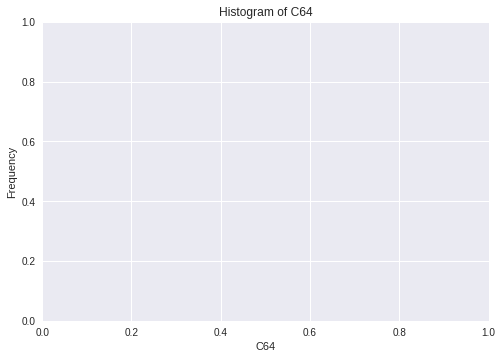

In [0]:
word_embeddings['C64'].hist()

In [0]:
low_c64_words = word_embeddings[word_embeddings["C64"] < -0.8]
low_c64_words[["Word", "C64"]].head(15)

Word,C64
biodegradable,-0.850931
bisphenol,-0.898839
bowels,-0.907133
bpa,-0.811818
buckwheat,-1.12285
bulldog,-0.867981
clusters,-0.884484
digesting,-0.803601
eco,-0.855959
engineered,-0.862782


# Predict on New Reviews

In [0]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))


In [0]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model, gbm_plus_summary))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_plus_summary))

Good Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C1': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C2': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C3': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C4': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C5': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.6/dist-packages/h2o/job.py:69: UserWarning: Test/Validation dataset is missing column 'summary_C6': substit

predict,p0,p1
1,0.356042,0.643958



None
Bad Review: 
gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.735046,0.264954



None


In [0]:
h2o.cluster().shutdown()

## About the Tokenize function 

In [0]:
test = 'My 2000, a two [] Corgis "were" thoroughly spoiled by my late husband  (I spent a year and a half dieting them down a combined total of 25 pounds!)'
test = h2o.H2OFrame.from_python({'String': test}).ascharacter()


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
test

String
"My 2000, a two [] Corgis ""were"" thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)"


In [0]:
tokenized_lower = test.tokenize('\\W+').tolower()
tokenized_lower, len(tokenized_lower)

C1
my
2000
a
two
corgis
were
thoroughly
spoiled
by
my


(, 29)

In [0]:
tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >=2)|tokenized_lower.isna()]
tokenized_filtered, len(tokenized_filtered)

C1
my
2000
two
corgis
were
thoroughly
spoiled
by
my
late


(, 24)

In [0]:
tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]

In [0]:
tokenized_words, len(tokenized_words)

C1
my
two
corgis
were
thoroughly
spoiled
by
my
late
husband


(, 22)

In [0]:
tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]

In [0]:
tokenized_words, len(tokenized_words)

C1
two
corgis
thoroughly
spoiled
late
husband
spent
year
half
dieting


(, 22)